In [104]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

pd.set_option('display.max_columns',None)

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

In [18]:
data_dir = Path('data')

store_sales = pd.read_csv(
    data_dir / 'train.csv',
    usecols=['store_nbr','family','date','sales','onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr','family','date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family','date'])
    .mean()
    .unstack('family')
    .loc['2017',['sales','onpromotion']]
)

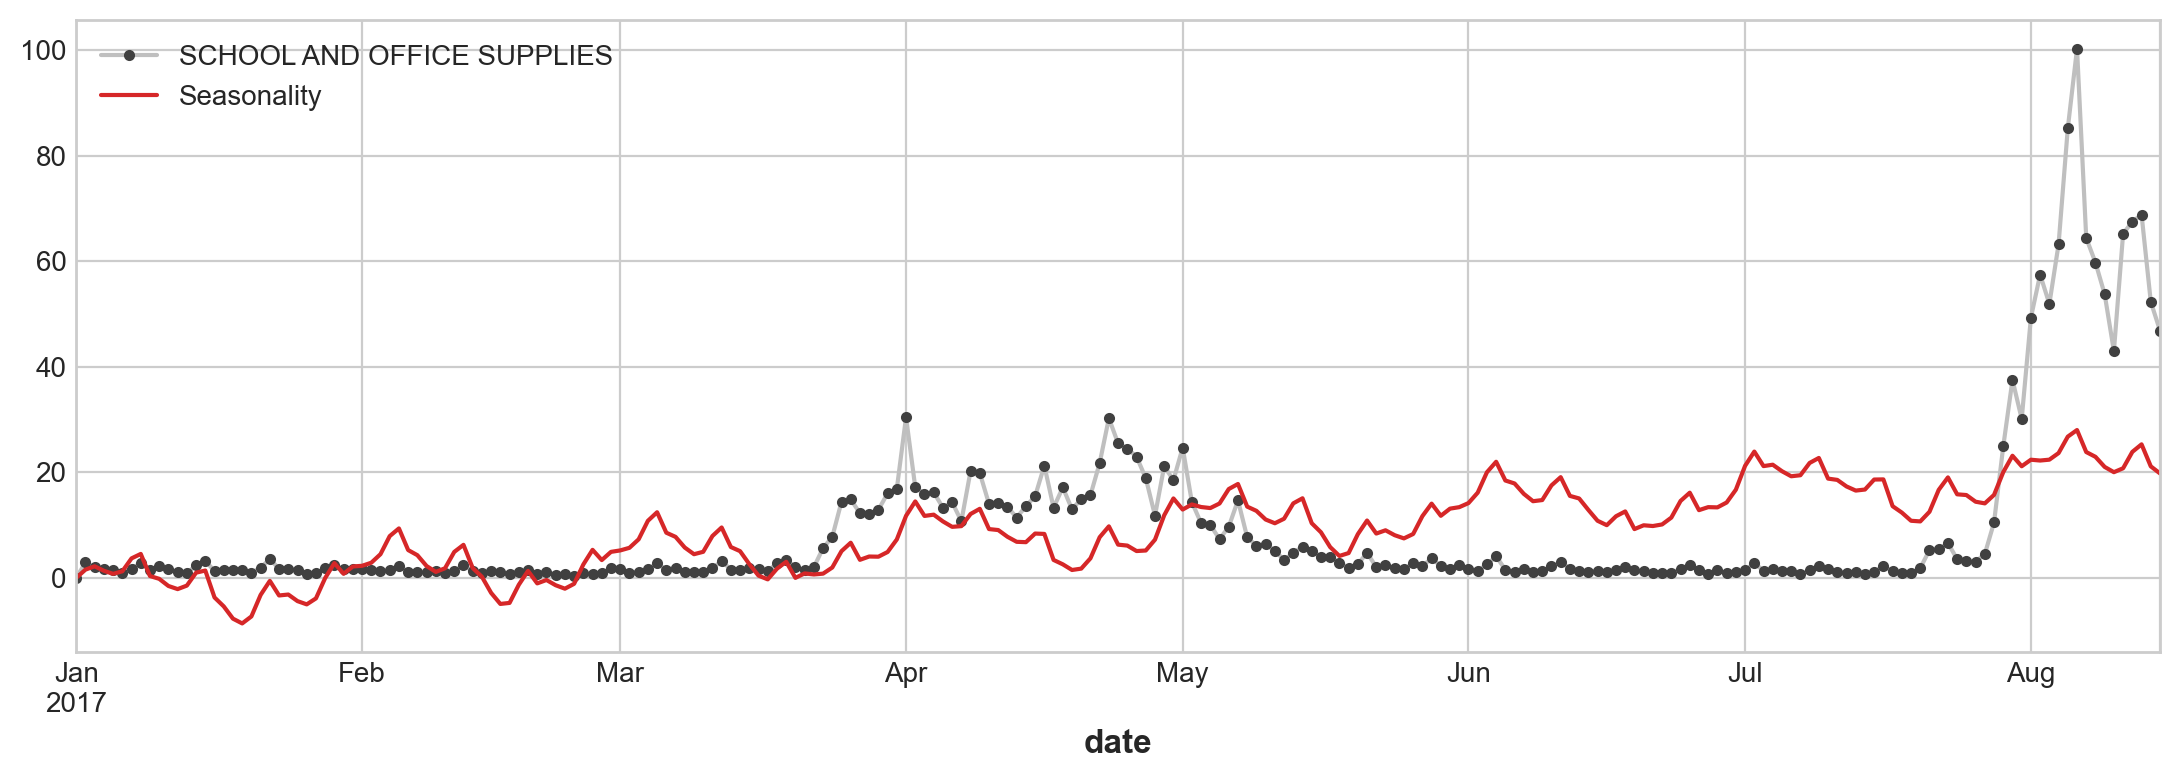

In [44]:
supply_sales = family_sales.loc(axis=1)[:,'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:,'sales'].squeeze()

fourier = CalendarFourier(freq='M',order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)


X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time,y)

seasonality = pd.Series(model.predict(X_time),index=X_time.index)

ax = y.plot(**plot_params)
_ = seasonality.plot(color='C3',ax=ax,label='Seasonality')
ax.legend()

#### Deseason

Text(0.5, 1.0, 'Sales of School and Office Supplies (deseasoned)')

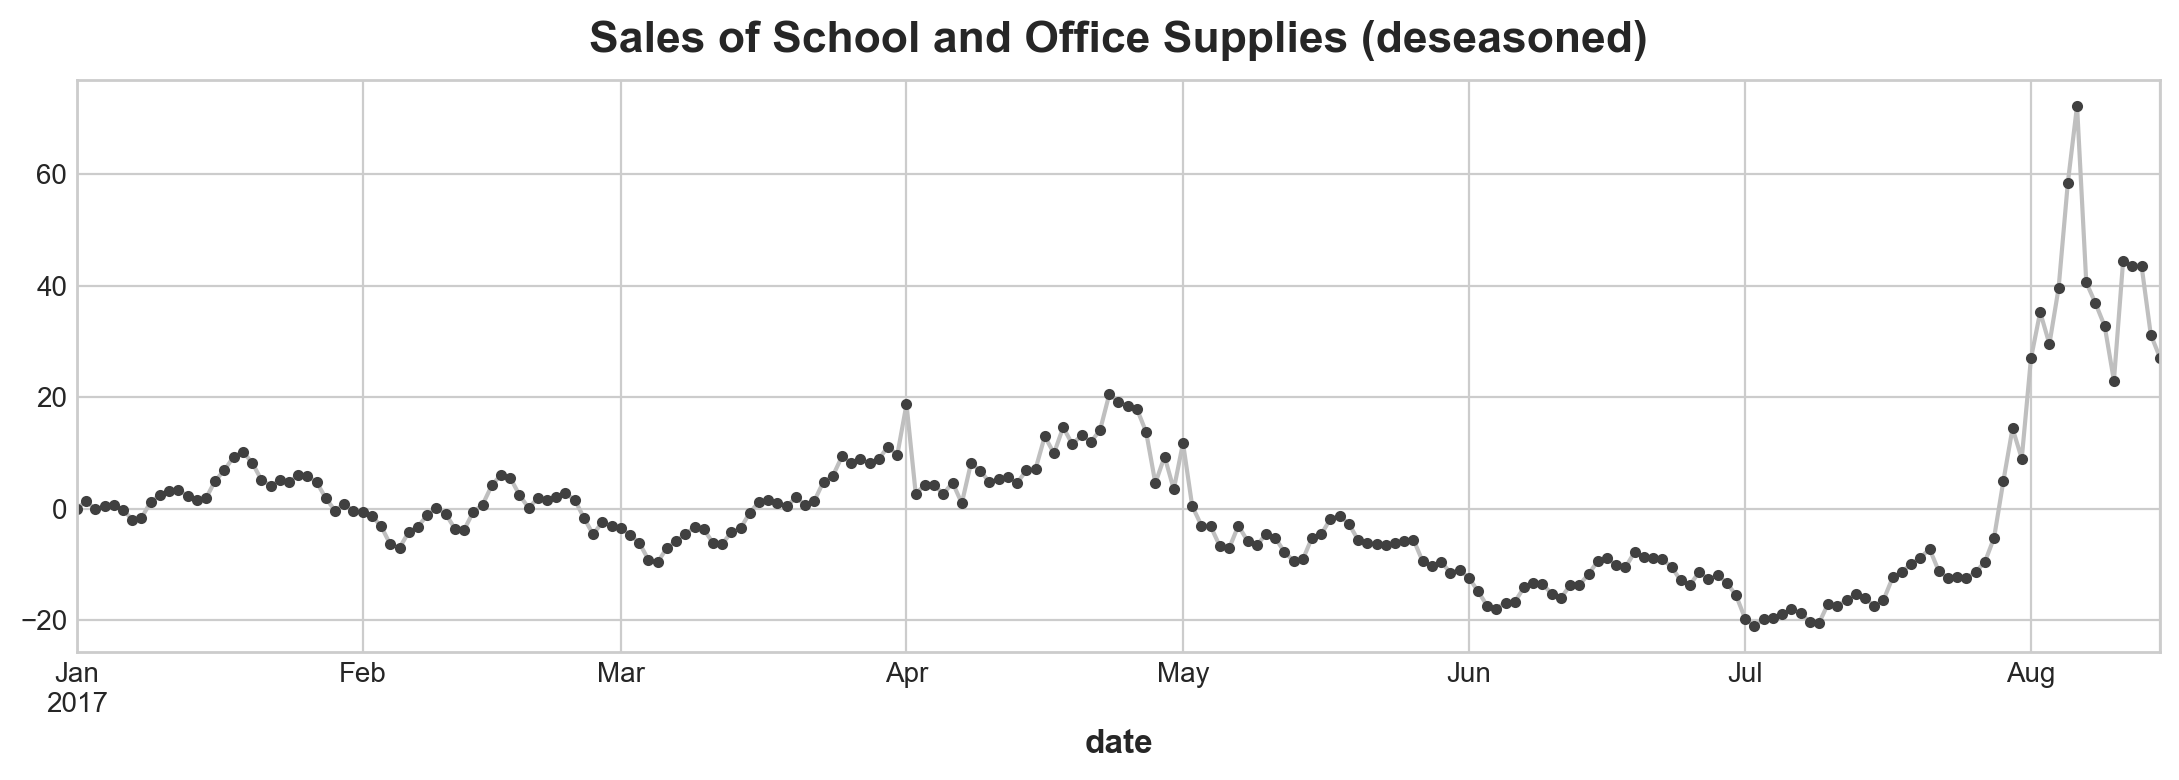

In [47]:
deseasoned = y - seasonality
deseasoned.name = 'sales_deseasoned'

ax = deseasoned.plot(**plot_params)
ax.set_title('Sales of School and Office Supplies (deseasoned)')

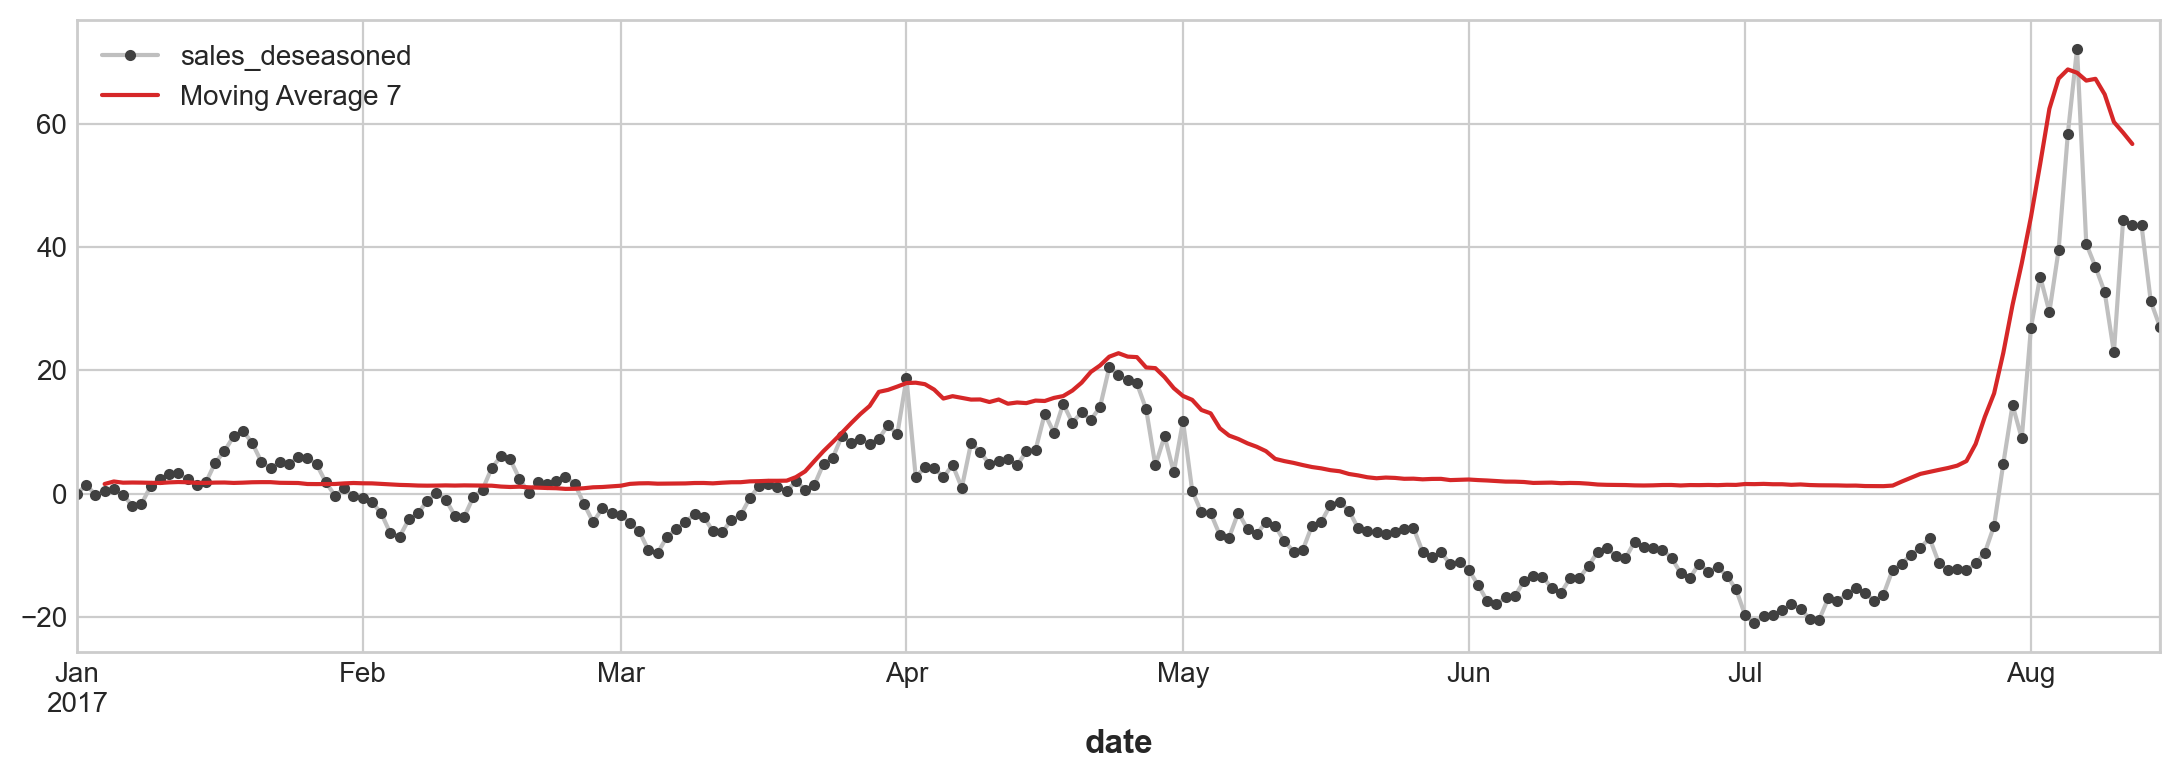

In [53]:

y_ma = y.rolling(window=7,center=True).mean()

ax = deseasoned.plot(**plot_params)
_ = y_ma.plot(color='C3',ax=ax, label='Moving Average 7')

ax.legend()

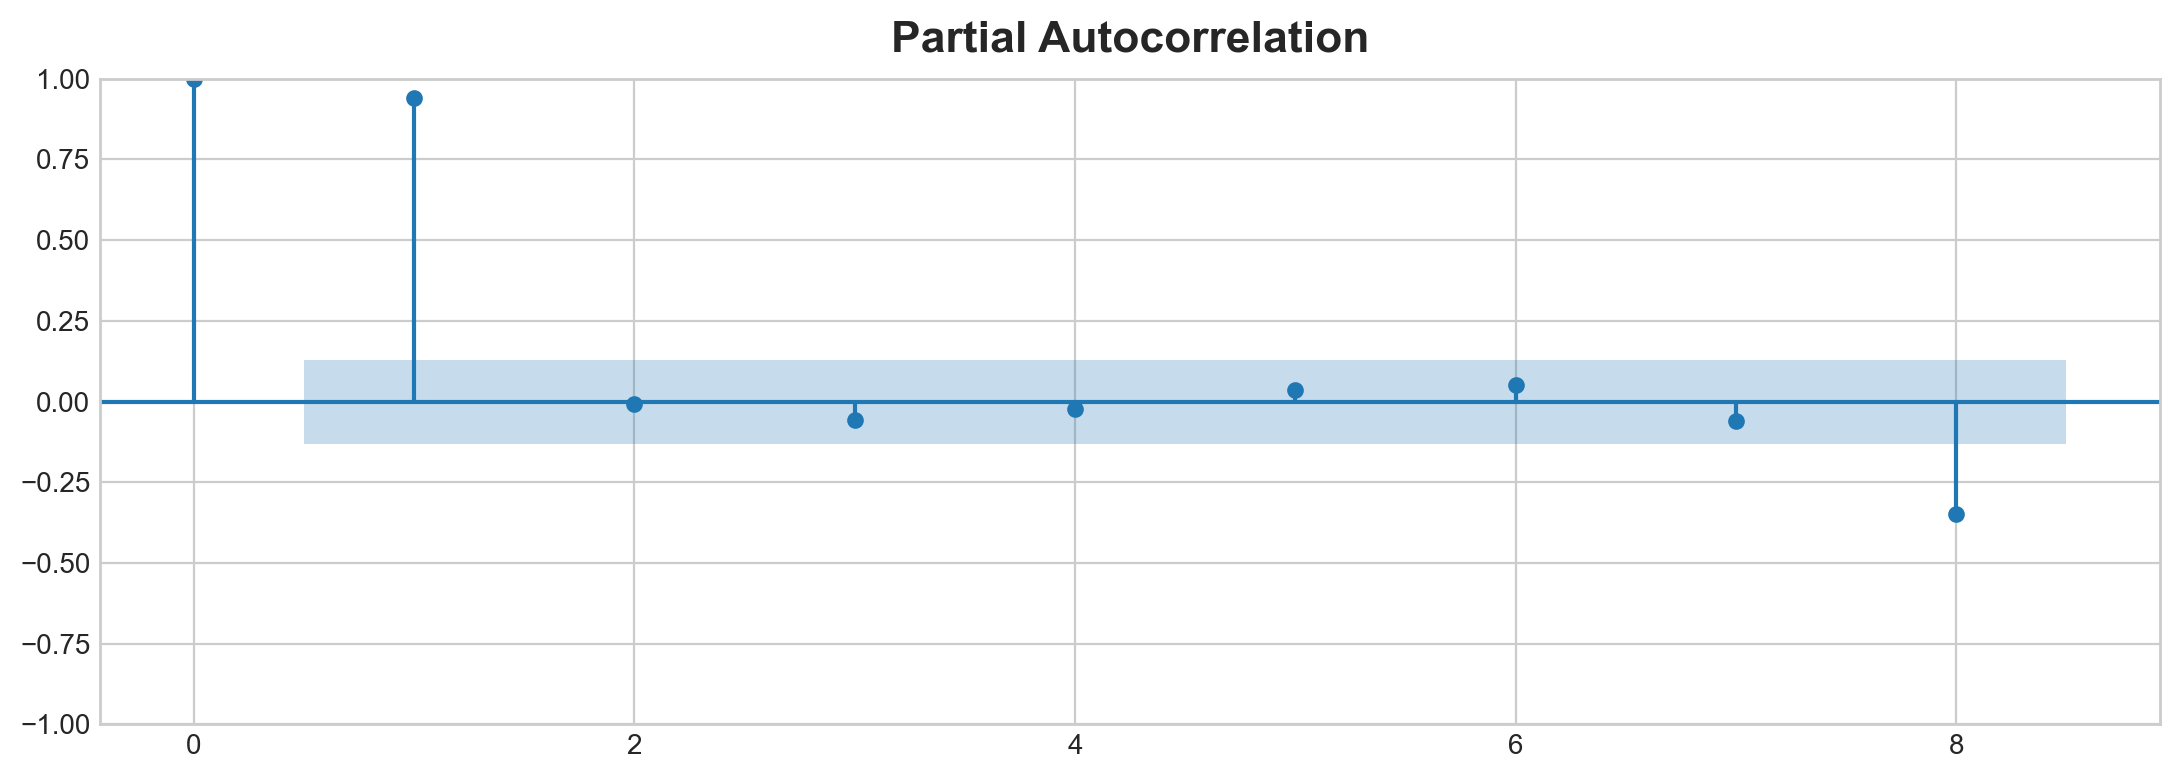

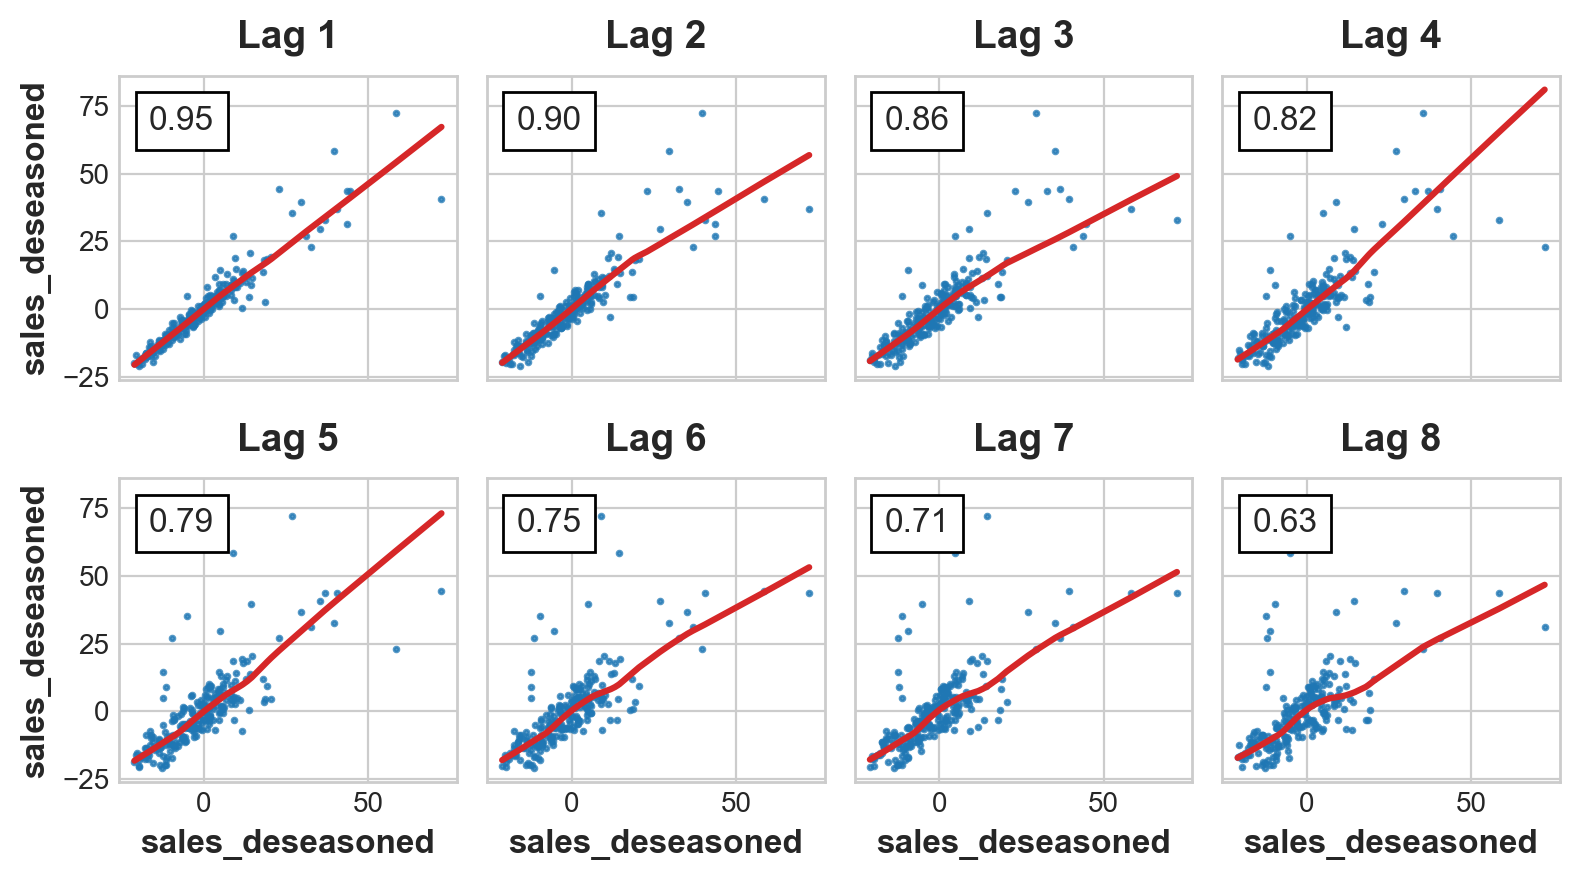

In [59]:
plot_pacf(deseasoned,lags=8)
plot_lags(deseasoned,lags=8,nrows=2)

plt.show()

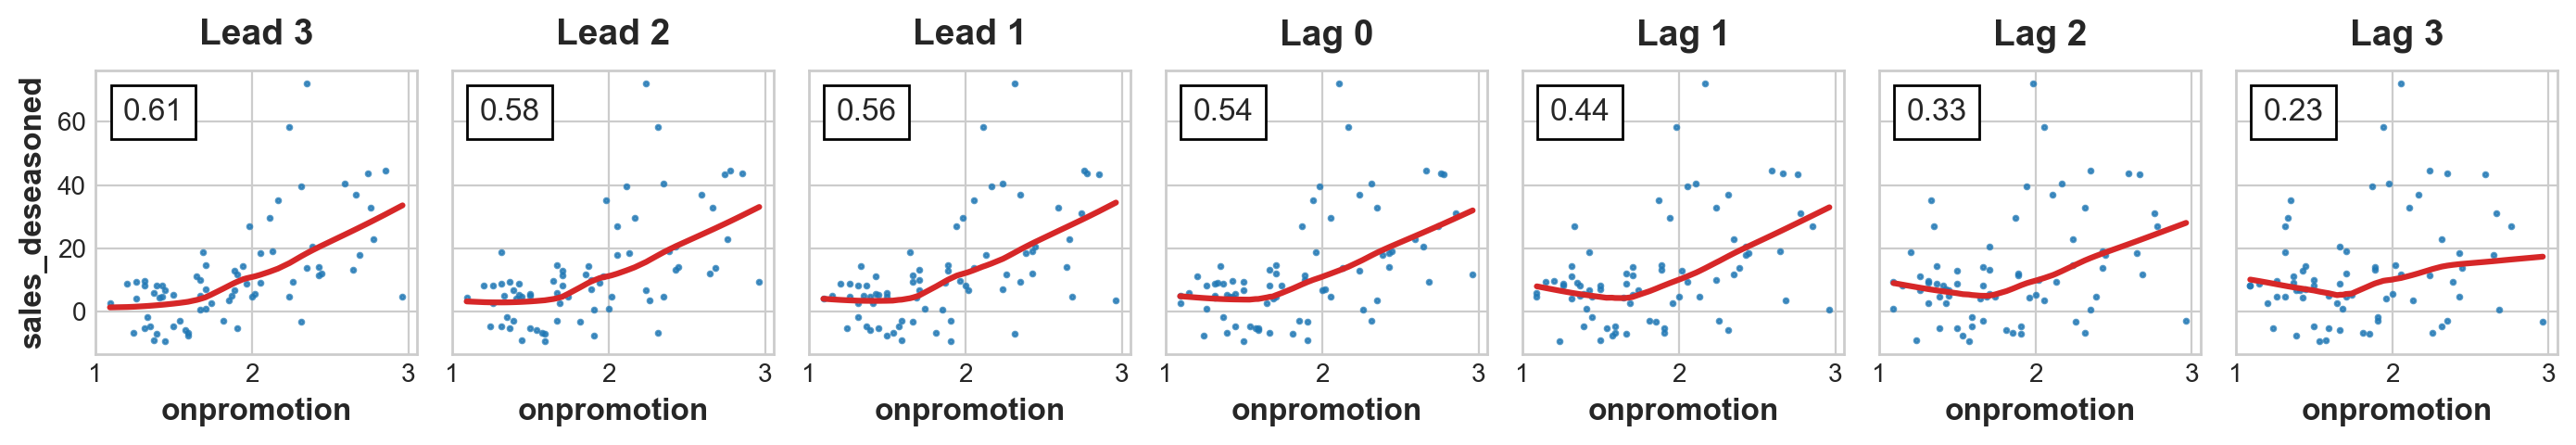

In [68]:
onpromotion = supply_sales.loc[:,'onpromotion'].squeeze().rename('onpromotion')

plot_lags(x=onpromotion.loc[onpromotion > 1], y = deseasoned.loc[onpromotion > 1], lags=3, leads=3, nrows=1)

plt.show()

In [93]:
X_lags = make_lags(ts=deseasoned, lags=1)
X_promo = pd.concat(
    [
        make_lags(lags=1,ts=deseasoned),
        onpromotion,
        make_leads(leads=1,ts=deseasoned)
    ],
    axis=1
)
                    
X = pd.concat([X_lags,X_promo],axis=1).dropna()
y,X = y.align(X,join='inner')

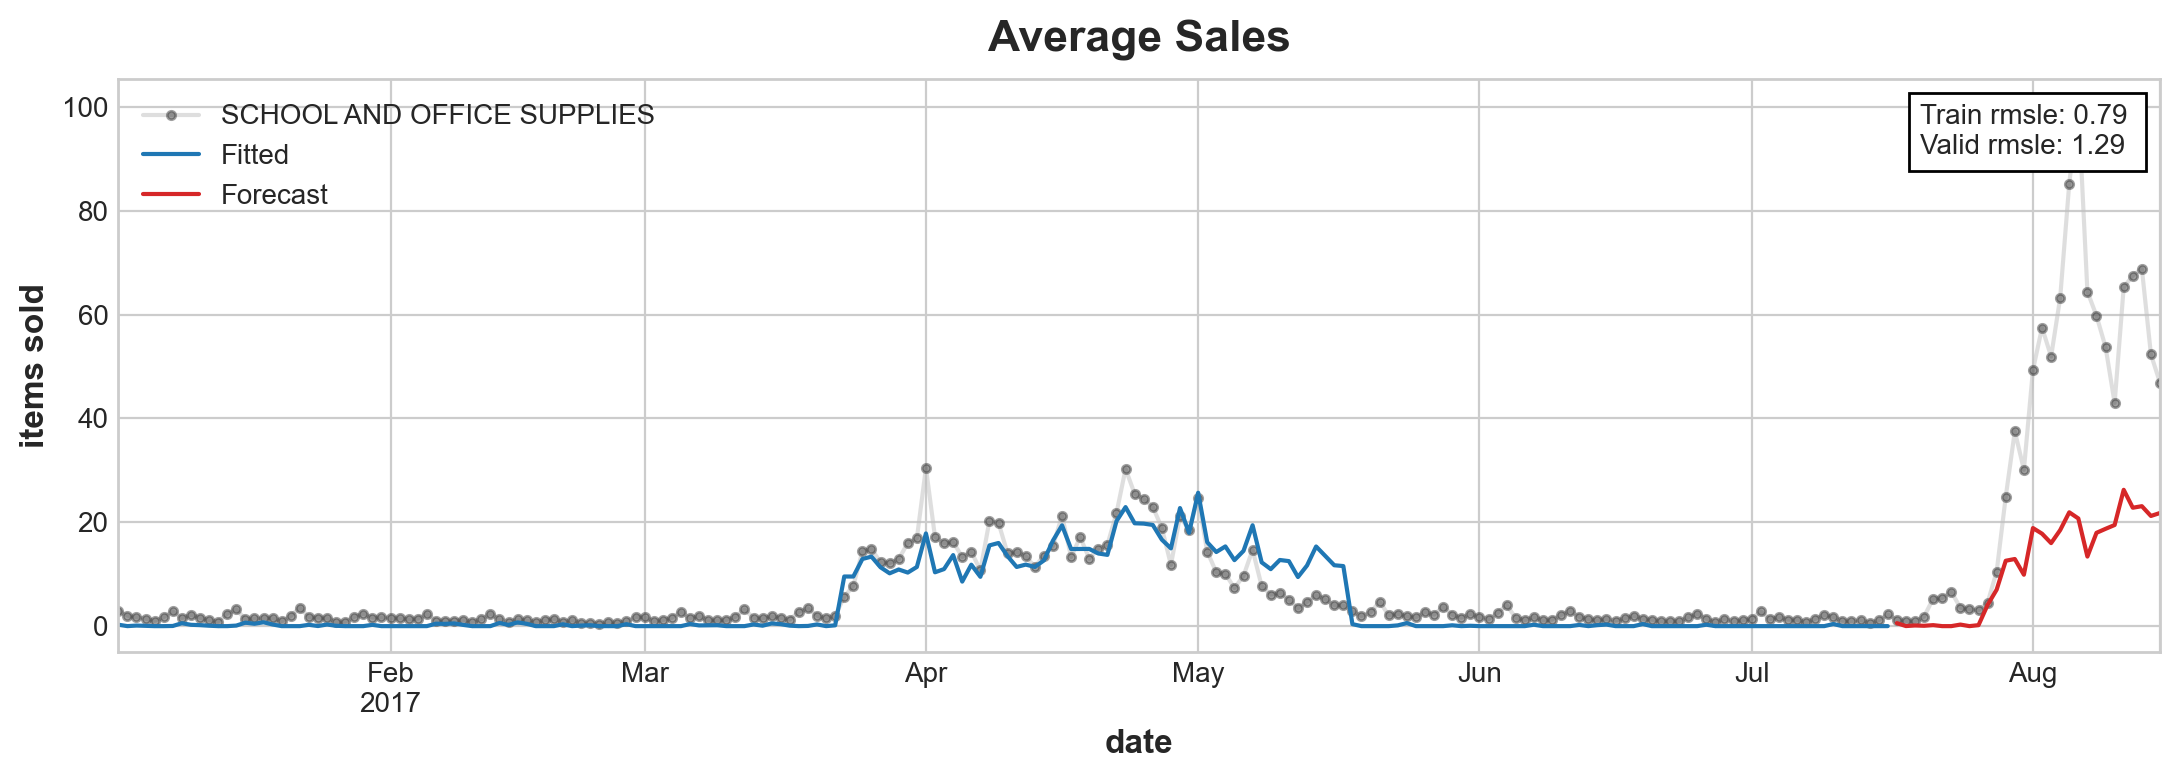

In [109]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=30,shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

ax = y.plot(**plot_params,alpha=0.5, title='Average Sales',ylabel='items sold')
ax = y_fit.plot(ax=ax,label='Fitted',color='C0')
ax = y_pred.plot(ax=ax, label='Forecast',color='C3')

rmsle_train = mean_squared_log_error(y_train,y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid,y_pred)

at = AnchoredText(
    s=f'Train rmsle: {rmsle_train:.2f} \nValid rmsle: {rmsle_valid:.2f}',
    loc='upper right'
)

at.patch.set_boxstyle('square, pad=0.0')
ax.add_artist(at)
ax.legend()
plt.show()

In [110]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:,'onpromotion']

family,SCHOOL AND OFFICE SUPPLIES
date,
2017-01-01,NaN
2017-01-02,0.000000
2017-01-03,2.925926
2017-01-04,2.018518
2017-01-05,1.722222
...,...
2017-08-11,42.962963
2017-08-12,65.240738
2017-08-13,67.481483
